In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import albumentations

from PIL import Image

from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4


In [74]:
class ClassificationDataset:
    def __init__(self, im_paths, targets, resize=None, augmentations=None):
        self.im_paths = im_paths 
        self.targets = targets 
        self.resize = resize 
        self.augmentations = augmentations 

    def __len__(self):
        return len(self.im_paths) 

    def __getitem__(self, item):
        image = Image.open(self.im_paths[item])
        
        targets = self.targets[item]

        if self.resize is not None:
            image = image.resize(
                                (self.resize[1], self.resize[0]),
                                resample=Image.BILINEAR
                                )
            
        image = np.array(image)
        
        return torch.tensor(image, dtype=torch.float), torch.tensor(targets, dtype=torch.float)

In [75]:
df = pd.read_csv('datasets/train_xray.csv')
images = df['im_path'].to_list() 
targets = df.target.values
train_images, valid_images, train_targets, valid_targets = train_test_split(
                                                                            images, targets, stratify=targets, random_state=42
                                                                            )

In [76]:
train_dataset = ClassificationDataset(im_paths=train_images, targets=train_targets, resize=(227, 227))
valid_dataset = ClassificationDataset(im_paths=valid_images, targets=valid_targets, resize=(227, 227))

In [77]:
import matplotlib.pyplot as plt

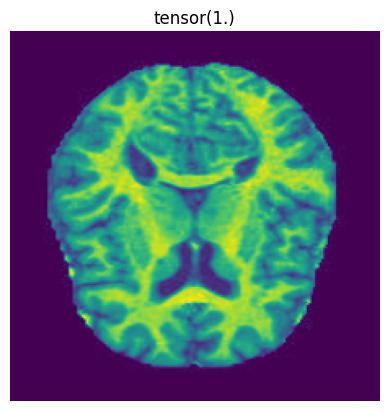

In [78]:
temp_img, temp_lab = train_dataset[1]
plt.imshow(temp_img)
plt.axis('off')
plt.title(temp_lab)
plt.show()

In [79]:
train_loader = torch.utils.data.DataLoader(
                                            train_dataset, batch_size=1, shuffle=True
                                            )

valid_loader = torch.utils.data.DataLoader(
                                            valid_dataset, batch_size=1, shuffle=False
                                            )

In [80]:
import torch.nn as nn
import torch.nn.functional as F




In [81]:
import torch.optim as optim



In [82]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # convolution part
        self.conv1 = nn.Conv2d(
                                in_channels=1,
                                out_channels=96,
                                kernel_size=11,
                                stride=4,
                                padding=0
                                )
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(
                                in_channels=96,
                                out_channels=256,
                                kernel_size=5,
                                stride=1,
                                padding=2
                                )
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(
                                in_channels=256,
                                out_channels=384,
                                kernel_size=3,
                                stride=1,
                                padding=1
                                )
        self.conv4 = nn.Conv2d(
            in_channels=384,
            out_channels=384,
            kernel_size=3, 
            stride=1,
            padding=1
            )
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256,
        kernel_size=3,
        stride=1,
        padding=1
        )
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        # dense part
        self.fc1 = nn.Linear(
        in_features=9216,
        out_features=4096
        )
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(
        in_features=4096,
        out_features=4096
        )
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(
        in_features=4096,
        out_features=1
        )
    def forward(self, image):
        # get the batch size, channels, height and width
        # of the input batch of images
        # original size: (bs, 3, 227, 227)
        bs = image.size()[0]
        x = F.relu(self.conv1(image)) # size: (bs, 96, 55, 55)
        x = self.pool1(x) # size: (bs, 96, 27, 27)
        x = F.relu(self.conv2(x)) # size: (bs, 256, 27, 27)
        x = self.pool2(x) # size: (bs, 256, 13, 13)
        x = F.relu(self.conv3(x)) # size: (bs, 384, 13, 13)
        x = F.relu(self.conv4(x)) # size: (bs, 384, 13, 13)
        x = F.relu(self.conv5(x)) # size: (bs, 256, 13, 13)
        x = self.pool3(x) # size: (bs, 256, 6, 6)
        x = x.view(bs, -1) # size: (bs, 9216)
        x = F.relu(self.fc1(x)) # size: (bs, 4096)
        x = self.dropout1(x) # size: (bs, 4096)
        # dropout does not change size
        # dropout is used for regularization
        # 0.3 dropout means that only 70% of the nodes
        # of the current layer are used for the next layer
        x = F.relu(self.fc2(x)) # size: (bs, 4096)
        x = self.dropout2(x) # size: (bs, 4096)
        x = F.relu(self.fc3(x)) # size: (bs, 1000)
        # 1000 is number of classes in ImageNet Dataset
        # softmax is an activation function that converts
        # linear output to probabilities that add up to 1
        # for each sample in the batch
        x = torch.softmax(x, axis=1) # size: (bs, 1000)
        return x

In [83]:
net = AlexNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [87]:
from tqdm import tqdm

In [92]:
losses = []
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader, 0), desc="train loader"):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
   
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    losses.append(running_loss)

print('Finished Training')

train loader: 3840it [19:48,  3.23it/s]
train loader: 3840it [19:47,  3.23it/s]
train loader: 3840it [24:27,  2.62it/s]
train loader: 901it [05:48,  2.59it/s]


KeyboardInterrupt: 

In [93]:
[x/3840 for x in losses]

[0.8132616430521011, 0.8132616430521011, 0.8132616430521011]